<a href="https://colab.research.google.com/github/mehdihosseinimoghadam/Signal-Processing/blob/main/VAE_for_Melspectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DataLoader


In [1]:
import torch
from torch import nn
## Some imports
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as idp
import torch
import torchaudio
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd

In [2]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.figure(figsize=(10,30))
  plt.show(block=False)

In [3]:
plt.rcParams["figure.figsize"] = (20,4)
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
sample_rate = 16000

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

In [4]:
! pip install kaggle

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d luantm/speech-commands-tensorflow

100% 4.51G/4.51G [01:54<00:00, 53.4MB/s]
100% 4.51G/4.51G [01:54<00:00, 42.3MB/s]


In [ ]:
%%capture
!unzip /content/speech-commands-tensorflow.zip

## DataLoader Structure

- Class: EnglishCommands
  - __init__
  - __len__
  - __getitem__
   - change_sample_rate
   - right_padding
   - mix_down
   - transformations
   - cut_signal


In [8]:
import csv

with open('/content/speechdataset/SpeechDataset/testing_list.txt', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split("/") for line in stripped if line)
    with open('log.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('command', 'path'))
        writer.writerows(lines)

In [9]:
from matplotlib.cbook import get_label
from torch.utils.data import Dataset
import torchaudio
class EnglishCommands(Dataset):
  def __init__(self,
               annotation_file,
               audio_dir,
               target_sample_rate,
               transformation,
               num_sample):


    self.annotation_file = pd.read_csv(annotation_file)
    self.audio_dir = audio_dir
    self.target_sample_rate = target_sample_rate
    self.transformation = transformation
    self.num_sample = num_sample


  def __len__(self):
    return len(self.annotation_file)


  def __getitem__(self, index):
    path = self.get_path(index)
    label = self.get_label(index)
    signal, sr = torchaudio.load(path)
    signal = self.change_sample_rate(signal, sr)
    signal = self.right_padding(signal)
    signal = self.cut_signal(signal)
    signal = self.transformation(signal)
    return signal, label



  def get_path(self, index):
    path = str(self.audio_dir) + "/" + str(self.annotation_file.iloc[index,0]) + "/" + str(self.annotation_file.iloc[index,1])  
    return path


  def get_label(self, index):  
    return self.annotation_file.iloc[index,0]

  def change_sample_rate(self, signal, sr):
    if sr != self.target_sample_rate:  
       signal = torchaudio.transforms.Resample(sr, self.target_sample_rate)
       return signal  
    return signal   

  def right_padding(self, signal):
    if signal.shape[1] < self.num_sample:
      padd = self.num_sample - signal.shape[1] 
      last_dim_padding = (0, padd)
      signal = torch.nn.functional.pad(signal, last_dim_padding)
      return signal
    return signal  


  def cut_signal(self, signal): 
    if signal.shape[1] > self.num_sample:
       signal = signal[:, :self.num_sample]
       return signal
    return signal   


11005
(tensor([[[3.1765e-05, 2.4714e-05, 8.6942e-05,  ..., 3.2994e-06,
          5.2515e-05, 2.9517e-04],
         [3.4465e-05, 1.6069e-04, 6.8403e-05,  ..., 5.5121e-05,
          6.2665e-05, 5.1782e-04],
         [5.4711e-05, 2.7495e-04, 2.4050e-04,  ..., 4.7274e-05,
          3.0108e-05, 9.5647e-04],
         ...,
         [2.3432e-05, 3.5740e-05, 7.1469e-04,  ..., 2.8967e-05,
          2.1059e-05, 1.1507e-05],
         [1.8408e-05, 2.2305e-05, 5.6248e-04,  ..., 3.5223e-05,
          4.0180e-05, 2.4511e-05],
         [1.5741e-05, 2.3770e-05, 2.5504e-04,  ..., 1.5882e-05,
          3.2086e-05, 3.2830e-05]]]), 'right')
torch.Size([1, 128, 32])


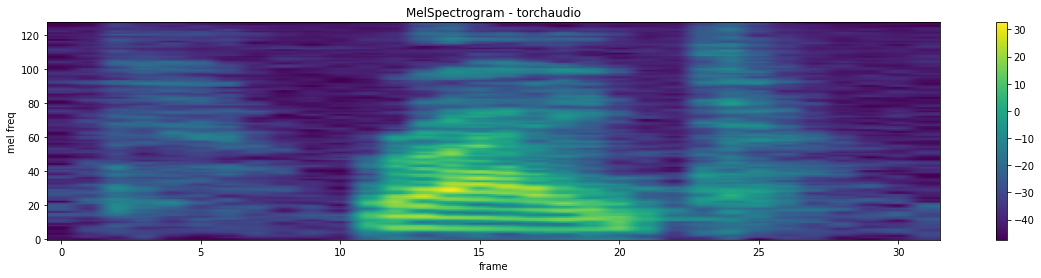

<Figure size 720x2160 with 0 Axes>

In [37]:
SR = 16000
N_FFT=1024
HOP_LENGTH=512
N_MELS=128

melspec = torchaudio.transforms.MelSpectrogram(sample_rate = SR,
                                               n_fft = N_FFT,
                                               window_fn = torch.hann_window,
                                               hop_length = HOP_LENGTH,
                                               n_mels = N_MELS)

EC = EnglishCommands("/content/log.csv",
                "/content/speechdataset/SpeechDataset",
                16000,
                melspec,
                16000)

print(len(EC))
print(EC[6])
print(EC[6][0].shape)

plot_spectrogram(
    EC[6][0][0], title="MelSpectrogram - torchaudio", ylabel='mel freq')
ipd.Audio(EC.get_path(6))

## Full VAE Code

In [58]:
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm2d
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(SimpleConvBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels,
                  out_channels,
                  **kwargs),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()          
    )
  def forward(self, x):
    return self.conv(x)


class DilatedConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, dilation, **kwargs):
    super(DilatedConvBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels,
                  out_channels,
                  dilation=dilation, 
                  **kwargs),
        nn.BatchNorm2d(out_channels),
        nn.ReLU() 
    )
  def forward(self, x):
    return self.conv(x)



class OnebyOneConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OnebyOneConvBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, 
                  out_channels,
                  1,
                  1,
                  0),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()          
    )
  def forward(self, x):
    return self.conv(x)






class Encoder(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Encoder, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels

    self.fc_mu = nn.Linear(75*8*2*out_channels, 4096)
    self.fc_logvar = nn.Linear(75*8*2*out_channels, 4096)

    self.simpleconv3x3 = SimpleConvBlock(self.in_channels,
                                      self.out_channels,
                                      kernel_size=3,
                                      stride=1,
                                      padding=1)

    self.simpleconv5x5 = SimpleConvBlock(self.in_channels,
                                      self.out_channels,
                                      kernel_size=5,
                                      stride=1,
                                      padding=2)
    
    self.simpleconv7x7 = SimpleConvBlock(self.in_channels,
                                      self.out_channels,
                                      kernel_size=7,
                                      stride=1,
                                      padding=3)   



    self.DilatedConvBlock2x2 = DilatedConvBlock(self.in_channels,
                                             self.out_channels,
                                             kernel_size = 3,
                                             stride = 1,
                                             padding = 2,
                                             dilation = 2)

    self.DilatedConvBlock4x4 = DilatedConvBlock(self.in_channels,
                                             self.out_channels,
                                             kernel_size = 3,
                                             stride = 1,
                                             padding = 4,
                                             dilation = 4)


    self.OnebyOneConvBlock = OnebyOneConvBlock(self.out_channels, 
                                               self.out_channels * 2)
    


    self.ConvList = nn.ModuleList()
    for i in range(1,5):
      self.ConvList.append(nn.Conv2d(
              self.out_channels * 15 *i ,
              self.out_channels * 15 *(i+1),
              4,
              2,
              1 
          ))
      # self.ConvList.append(nn.BatchNorm2d(self.out_channels * 15 *(i+1)))
      # self.ConvList.append(nn.ReLU())
   

  def forward(self, x):
      x = torch.cat([self.simpleconv3x3(x),
                     self.simpleconv5x5(x),
                     self.simpleconv7x7(x),
                     self.DilatedConvBlock2x2(x),
                     self.DilatedConvBlock4x4(x),

                     self.OnebyOneConvBlock(self.simpleconv3x3(x)),
                     self.OnebyOneConvBlock(self.simpleconv5x5(x)),
                     self.OnebyOneConvBlock(self.simpleconv7x7(x)),
                     self.OnebyOneConvBlock(self.DilatedConvBlock2x2(x)),
                     self.OnebyOneConvBlock(self.DilatedConvBlock4x4(x))] , axis = 1)
      print(x.shape)
      for i in self.ConvList:
        x = i(x)
        print(x.shape, i)
      x = x.reshape(x.shape[0], -1)
      # x = self.fc(x)
      # return x 
      x_mu = self.fc_mu(x)
      x_logvar = self.fc_logvar(x)
      return x_mu, x_logvar







class Decoder(nn.Module):
    def __init__(self, out_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=4096, out_features=75*8*2*out_channels)
        self.conv1 = nn.ConvTranspose2d(in_channels=75*out_channels, out_channels=75, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=75, out_channels=50, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(in_channels=50, out_channels=40, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(in_channels=40, out_channels=30, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.ConvTranspose2d(in_channels=12, out_channels=6, kernel_size=4, stride=2, padding=1)
        self.conv6 = nn.ConvTranspose2d(in_channels=25, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 150, 8, 2) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        print(x.shape)
        x = F.relu(self.conv1(x))
        print(x.shape)
        x = F.relu(self.conv2(x))
        print(x.shape)
        x = F.relu(self.conv3(x))
        print(x.shape)
        # x = F.relu(self.conv4(x))
        print(x.shape)
        # x = F.relu(self.conv5(x))
        x = torch.sigmoid(self.conv4(x))
        print(x.shape) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    



class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(1,2)
        self.decoder = Decoder(2)
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 30* 128* 32), x.view(-1, 30* 128* 32), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + 1 * kldivergence
    
    
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 30371418


In [59]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
train_dataloader = DataLoader(EC, batch_size=1, shuffle=True)

In [60]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=.001, weight_decay=1e-5)
device = "cuda" if torch.cuda.is_available() else "cpu"
# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(1):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
torch.Size([1, 30, 128, 32])
torch.Size([1, 60, 64, 16]) Conv2d(30, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
torch.Size([1, 90, 32, 8]) Conv2d(60, 90, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
torch.Size([1, 120, 16, 4]) Conv2d(90, 120, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
torch.Size([1, 150, 8, 2]) Conv2d(120, 150, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
torch.Size([1, 150, 8, 2])
torch.Size([1, 75, 16, 4])
torch.Size([1, 50, 32, 8])
torch.Size([1, 40, 64, 16])
torch.Size([1, 40, 64, 16])
torch.Size([1, 30, 128, 32])


RuntimeError: ignored